In [2]:
import numpy
import paddle

import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger
from paddle_quantum.state import zero_state
from paddle import matmul, trace


def Paddle_VQLS(A, b, x, N=5, ITR=4000, LR=0.001, DEPTH=8):
    r"""Paddle_VQLS
    
    Args:
        A: differential operator discretized into a matrix 
        b: driving term
        N: Width of QNN
        ITR: Number of iterations
        LR: Learning rate
    
    Returns: 
        x: Solution of the linear system Ax=b
    """
    paddle_quantum.set_backend("state_vector")
    
    summary_iter, summary_loss = [], []
    
    A = paddle.to_tensor(A, dtype=paddle_quantum.get_dtype())
    b = paddle.to_tensor(b, dtype=paddle_quantum.get_dtype())
    x = paddle.to_tensor(x, dtype=paddle_quantum.get_dtype())
    
    # Fix the dimensions of network
    net = Circuit(N)
#     net.universal_two_qubits([0, 1])
    net.complex_entangled_layer(depth=DEPTH)
    net.ry(qubits_idx='full')

    # Use Adagrad optimizer
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # Optimization iterations
    for itr in range(ITR+10):
        U = net.unitary_matrix()
#         print("U=", U)
        # Run forward propagation to calculate loss function and obtain energy spectrum
#         psi = paddle.to_tensor(psi.numpy(), dtype = paddle_quantum.get_dtype())
        basis = paddle.eye(2**N, 1)
#         print("basis =", basis)
        vec = U @ basis 
#         print("vec=", vec)
        psi_fin = matmul(A, vec) 
#         print("psi=", psi_fin)
#         print("b", b)
#         print("fid=", matmul(b, psi_fin).numpy()**2)
        
        # Calculate loss function
        fid = paddle.abs(matmul(x, psi_fin)) @ paddle.abs(matmul(x, psi_fin))
        psi_norm = paddle.abs(matmul(psi_fin.conj().t(), psi_fin)) 
        loss = 1 - fid/psi_norm
        x_np = psi_fin.numpy()

        # In dynamic graph, run backward propagation to minimize loss function
        loss.backward()
        opt.minimize(loss)
        opt.clear_grad()
        
        summary_loss.append(loss.numpy()[0])
        summary_iter.append(itr)

        # Print results
        if itr % 10 == 0:
            print('iter:', itr, 'loss:', loss.numpy()[0])

    return x_np, summary_loss, summary_iter

In [3]:
import numpy as np
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

N = 5   # number of qubits
dim = 2**N # dimension of the operator A

# Setup a tridiagonal matrix
k = [np.ones(dim-1), -2*np.ones(dim), np.ones(dim-1)]
offset = [-1, 0, 1]
A = diags(k,offset).toarray()

# Setup the driving term f(x) = x
b = np.linspace(0, 1, dim)
h = 1/(dim-1)
sampled_b = b*(h**2)
bt = np.linspace(0, 1, dim)

# Setup the Dirichlet B.C.s
phi_a, phi_b = 0, 0
sampled_b[0] -= phi_a
sampled_b[dim-1] -= phi_b
norm = np.linalg.norm(sampled_b)
sampled_b = sampled_b/norm

# Solve the linear system of equations
x = np.linalg.solve(A, sampled_b)
f = np.linalg.norm(x)
x = x/f

# Build Hamiltonian
# sampled_b = sampled_b.reshape([dim, 1])
Hamiltonian = A@(np.eye(dim)- sampled_b@sampled_b.T)@A

In [4]:
quantum_solution, summary_loss, summary_iter = Paddle_VQLS(A, sampled_b, x)

/Users/jacksong/opt/anaconda3/envs/paddle_quantum_env/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


iter: 0 loss: [0.9999995]
iter: 10 loss: [0.9999991]
iter: 20 loss: [0.9999985]
iter: 30 loss: [0.9999977]
iter: 40 loss: [0.9999965]
iter: 50 loss: [0.9999948]
iter: 60 loss: [0.9999925]
iter: 70 loss: [0.9999892]
iter: 80 loss: [0.99998426]
iter: 90 loss: [0.99997634]
iter: 100 loss: [0.999962]
iter: 110 loss: [0.99993265]
iter: 120 loss: [0.9998726]
iter: 130 loss: [0.99977803]
iter: 140 loss: [0.99965733]
iter: 150 loss: [0.9994706]
iter: 160 loss: [0.9991335]
iter: 170 loss: [0.9984423]
iter: 180 loss: [0.9970362]
iter: 190 loss: [0.99430317]
iter: 200 loss: [0.9902112]
iter: 210 loss: [0.9850643]
iter: 220 loss: [0.97837627]
iter: 230 loss: [0.9694928]
iter: 240 loss: [0.958785]
iter: 250 loss: [0.94623595]
iter: 260 loss: [0.9322535]
iter: 270 loss: [0.9173437]
iter: 280 loss: [0.901759]
iter: 290 loss: [0.8869754]
iter: 300 loss: [0.8739699]
iter: 310 loss: [0.85703385]
iter: 320 loss: [0.8469851]
iter: 330 loss: [0.82984984]
iter: 340 loss: [0.8195445]
iter: 350 loss: [0.80917

iter: 2800 loss: [0.01478648]
iter: 2810 loss: [0.01100659]
iter: 2820 loss: [0.01861829]
iter: 2830 loss: [0.01977551]
iter: 2840 loss: [0.01463562]
iter: 2850 loss: [0.01670855]
iter: 2860 loss: [0.0165444]
iter: 2870 loss: [0.01510918]
iter: 2880 loss: [0.01711935]
iter: 2890 loss: [0.0151841]
iter: 2900 loss: [0.01839]
iter: 2910 loss: [0.01604778]
iter: 2920 loss: [0.01566982]
iter: 2930 loss: [0.01575792]
iter: 2940 loss: [0.01458544]
iter: 2950 loss: [0.01375341]
iter: 2960 loss: [0.01371062]
iter: 2970 loss: [0.01812452]
iter: 2980 loss: [0.01637954]
iter: 2990 loss: [0.01561213]
iter: 3000 loss: [0.01496708]


In [5]:
qnorm = np.linalg.norm(quantum_solution)
quantum_solution = quantum_solution/qnorm
print(quantum_solution)

[[ 0.02701115-0.00118657j]
 [-0.00018292-0.03868385j]
 [ 0.04813354-0.04406511j]
 [ 0.05026792-0.05389684j]
 [ 0.05646506-0.08196507j]
 [ 0.05986209-0.08330461j]
 [ 0.06919847-0.10666863j]
 [ 0.11077469-0.1088718j ]
 [ 0.0771783 -0.1340521j ]
 [ 0.08302294-0.1495326j ]
 [ 0.11091391-0.14359488j]
 [ 0.10933397-0.17662631j]
 [ 0.0988782 -0.1804677j ]
 [ 0.09917524-0.1888498j ]
 [ 0.1101555 -0.1918219j ]
 [ 0.1188476 -0.22569025j]
 [ 0.10442903-0.17897193j]
 [ 0.10261679-0.23118928j]
 [ 0.103703  -0.21275611j]
 [ 0.10371757-0.20618868j]
 [ 0.11776382-0.22833374j]
 [ 0.0750334 -0.19854312j]
 [ 0.09901012-0.21457401j]
 [ 0.09554348-0.19975236j]
 [ 0.08163321-0.16457765j]
 [ 0.06564846-0.19324806j]
 [ 0.07206292-0.16123565j]
 [ 0.07128711-0.1193899j ]
 [ 0.03478539-0.14262764j]
 [ 0.05078613-0.07066186j]
 [ 0.02230998-0.08834411j]
 [ 0.02307648-0.01580628j]]


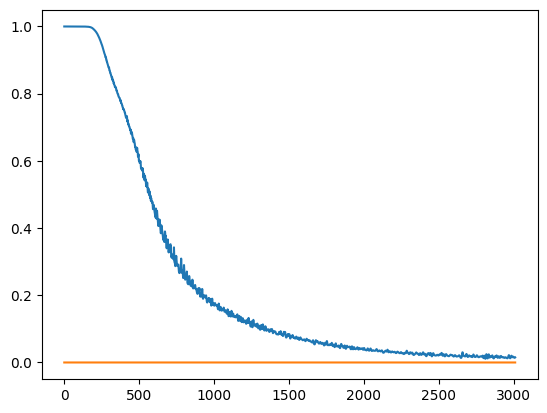

In [6]:
plt.plot(summary_iter, summary_loss)
plt.plot(summary_iter, np.zeros(len(summary_iter))) 

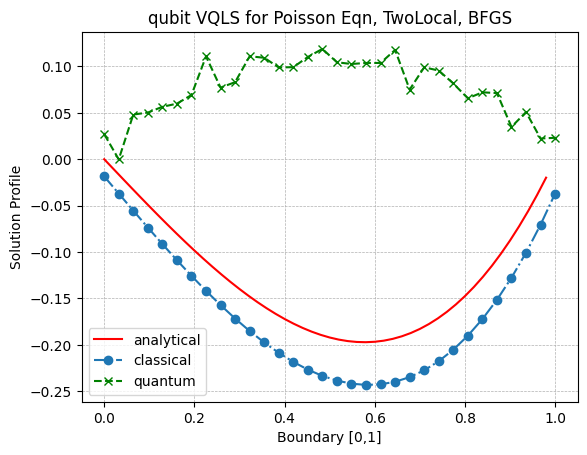

In [8]:
t = np.arange(0., 1., 0.02)
res = (t**3-t)/6
norm_res = np.linalg.norm(res)
res_norm = res/norm_res

xt = np.arange(0,1,1/dim)
exact = [1/6*(x**3-x) for x in np.arange(0,1,1/dim)]
norm = np.linalg.norm(exact)
exact = exact/norm

# red dashes, blue squares and green triangles
plt.plot(t, res_norm, 'r-', label='analytical')
plt.plot(bt, x, 'o-.', label='classical')
plt.plot(bt, quantum_solution, 'gx--', label='quantum')
# plt.legend()
plt.legend(loc="lower left")
plt.xlabel('Boundary [0,1]')
plt.ylabel('Solution Profile')
plt.title("qubit VQLS for Poisson Eqn, TwoLocal, BFGS")
plt.grid(linestyle = '--', linewidth = 0.5)
# plt.show()
# plt.savefig("Poisson.png", bbox_inches='tight', dpi=300)